<a href="https://colab.research.google.com/github/callmemark/Correlation-of-Night-Air-Temperature-and-light-pollution-in-major-cities-in-the-Philippines/blob/PreTest/Thesis_Proc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Correlation of Night Air Temperature and light pollution in major cities in the Philippines </h1>
</br></br></br>


> Fernandez, Jaron Rix
</br>
Velmonte, Mark john A.



<br>
<br>
<br>

---








<h1>Preperation 1: Install Libraries</h1>

> Install neccesary libraries

In [ ]:

!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install --upgrade pip --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install ipywidgets --quiet

!pip install splot --quiet
!pip install -U mgwr --quiet

!pip install pyprocessmacro


<h1>Preperation 2: Import Libraries</h1>

> after installation we procced to import the libraries

In [ ]:
#import libraries

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from google.colab import drive
from os import path, getcwd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pyprocessmacro import Process

<h1> Preperation 3: Moun Drive </h1>

> To access data from google drive, We need to give permission to mount the drive and gain access to folders and files

In [ ]:
#mount the google drive used
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>Preperation 4: File Reference </h1>

> Create a dictionary to use for file path reference and for process automation

In [ ]:
GPKG_DATASET_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/GPKG_FILES/"


gpkg_files_dict = {
    "Manila_City" : "Manila_City.gpkg",
    "Taguig_City" : "Taguig_City.gpkg",
    "Pasig_City" : "Pasig_City.gpkg",
    "Paranaque_City" : "Paranaque_City.gpkg",
    "Makati_City" : "Makati_City.gpkg",
    "LasPinas_City" : "LasPinas_City.gpkg",
    "Muntinlupa_City" : "Muntinlupa_City.gpkg",
    "Pasay_City" : "Pasay_City.gpkg",
    "Malabon_City" : "Malabon_City.gpkg",
    "Butuan_City" : "Butuan_City.gpkg",
    "grouped_study_area" : "grouped_study_area.gpkg"  
}



DATASET_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/DataSet/climactic_factor_dataset_v2/"

CITY_NAME= [
    "manila_city",
    "valenzuela_city",
    "taguig_city",
    "pasig_city",
    "pasay_city",
    "paranaque_city",
    "muntinlupa_city",
    "malabon_city",
    "makati_city",
    "laspinas_city"
]


LIGHTPOL_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/DataSet/Light_pol_data/"

y_ext = ["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]
lpol_cname = [
  "manila_lpol_data_",
  "taguig_lpol_data_",
  "pasig_lpol_data_",
  "paranaque_lpol_data_",
  "makati_lpol_data_",
  "laspinas_lpol_data_",
  "muntinlupa_lpol_data_",
  "pasay_lpol_data_",
  "malabon_lpol_data_",
  "valenzuela_lpol_data_",
]

In [ ]:
GPKG_DATASET_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/GPKG_FILES/"


gpkg_files_dict = {
    "Manila_City" : "Manila_City.gpkg",
    "Taguig_City" : "Taguig_City.gpkg",
    "Pasig_City" : "Pasig_City.gpkg",
    "Paranaque_City" : "Paranaque_City.gpkg",
    "Makati_City" : "Makati_City.gpkg",
    "LasPinas_City" : "LasPinas_City.gpkg",
    "Muntinlupa_City" : "Muntinlupa_City.gpkg",
    "Pasay_City" : "Pasay_City.gpkg",
    "Malabon_City" : "Malabon_City.gpkg",
    "Butuan_City" : "Butuan_City.gpkg",
    "grouped_study_area" : "grouped_study_area.gpkg"  
}



DATASET_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/DataSet/climactic_factor_dataset_v2/"

CITY_NAME= [
    "manila_city",
    "valenzuela_city",
    "taguig_city",
    "pasig_city",
    "pasay_city",
    "paranaque_city",
    "muntinlupa_city",
    "malabon_city",
    "makati_city",
    "laspinas_city"
]


LIGHTPOL_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/DataSet/Light_pol_data/"

y_ext = ["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]
lpol_cname = [
  "manila_lpol_data_",
  "taguig_lpol_data_",
  "pasig_lpol_data_",
  "paranaque_lpol_data_",
  "makati_lpol_data_",
  "laspinas_lpol_data_",
  "muntinlupa_lpol_data_",
  "pasay_lpol_data_",
  "malabon_lpol_data_",
  "valenzuela_lpol_data_",
]

<h1>Preperation 5: Create helper function and class</h1>

> Create function and classes methods that will be use repeatedly

In [ ]:
# Helper functions and Classes
def get_gpk_fpath(city_name_arg = str):
  try:
    return GPKG_DATASET_DIRECTORY + gpkg_files_dict[city_name_arg]
  except:
    raise Exception("error in get_gpk_fpath func | No City in dataset")
    

def get_file_path(city_name_arg):
  _fstr = DATASET_DIRECTORY + city_name_arg + ".csv"
  return _fstr


In [ ]:
class MMREG_PROCS():
  def __init__(self, main_df_arg, x_axis, y_axis, x_axis_drop = [], drop_axis = 1, title_arg = "Data Analysis"):
    self.main_df = main_df_arg

    if len(x_axis_drop) == 0:
      self.x_sample = main_df_arg[x_axis]
    elif len(x_axis_drop) != 0:
      self.x_sample = main_df_arg.drop(x_axis_drop, axis = drop_axis)

    self.y_sample = main_df_arg[y_axis]
    
    self.proc_title = title_arg
    

  def get_init_val(self):
    print("X sample: ", self.x_sample)
    print("Y sample: ", self.y_sample)
  

  def standard_proc(self, _show_plot_arg = True):
    self.scikit_train_proc(show_plot_arg = _show_plot_arg)
    self.disp_res_header()
    self.scikit_proc()
    self.statmod_proc()

  
  def disp_res_header(self):
    print(("===" * 26), "'\n")
    print(self.proc_title.center(26, "="))


  def calc_pct(self):
    x_axis_pct_chage = pd.DataFrame(self.x_sample).pct_change()
    y_axis_pct_chage = pd.DataFrame(self.y_sample).pct_change()

    print(("===" * 26), "'\n")
    print("PCT: \n", x_axis_pct_chage, y_axis_pct_chage)
    print(("===" * 26), "'\n")
    return [x_axis_pct_chage, y_axis_pct_chage]


  def scikit_train_proc(self, test_size_arg = 0.3, random_state_arg = 0, show_plot_arg = True):
    self.lr_model = LinearRegression()
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x_sample, self.y_sample, test_size = test_size_arg, random_state = random_state_arg)
    self.lr_model.fit(self.X_train, self.y_train)
    self.y_pred = self.lr_model.predict(self.X_train)
    
    if show_plot_arg:
      plt.scatter(self.y_train, self.y_pred, color = "black")
      sns.regplot(x = self.y_train, y = self.y_pred , ci=None, color ='orange')

      plt.style.use('seaborn-pastel')
      plt.ylabel("Factors")
      plt.xlabel("N.Time Temp")
      plt.title(self.proc_title)

      plt.show()
    
    return [self.y_train, self.y_pred]


  def scikit_proc(self):
    regr = linear_model.LinearRegression()
    fitted_model = regr.fit(self.x_sample, self.y_sample)
    print(("===" * 26), "'\n")
    print("SCIKIT LEARN RESULT: ")
    print("Intercept: ", fitted_model.intercept_)
    print('Coefficients: ', fitted_model.coef_)
    print()
    print(("===" * 26), "'\n")

    return fitted_model


  def statmod_proc(self):
    _x = sm.add_constant(self.x_sample)
 
    model = sm.OLS(self.y_sample, _x).fit()
    predictions = model.predict(_x) 
    
    reg_ressult = model.summary()
    print(reg_ressult)

    return reg_ressult
  

  def vif(self, print_output = True):
    _result = [variance_inflation_factor(self.x_sample.values, i) for i in range(len(self.x_sample.columns))]
    return _result
  

  def mod_reg(self, independent_var, dependent_var, mediator_variable = []):
    p = Process(
        data = self.main_df, 
        model = 4, x = independent_var, 
        y = dependent_var, 
        m = mediator_variable)
    
    p.summary()

<h1>Procedures</h1>

> 1. get light pollution annual average per city
<br>
> 2. filter data to obtains night time information (7pm-4am)
<br>
> 3. Calculate the annaul average of every parameter for every city
<br>
> 4. Create new Data frame for every city obtaining the night time annual average value of parameters
<br>
> 5. Combine all the processed data into a single dataset 

<h1>Procedure 1</h1>

> 1. get light pollution annual average per city



In [ ]:
dict_keys = ['Manila_City', 'Taguig_City', 'Pasig_City', 'Paranaque_City', 'Makati_City', 'Las Pinas_City', 'Muntinlupa_City', 'Pasay_City', 'Malabon_City', 'Valenzuela_City']
lpol_data_dict = {}

for _index in range(len(lpol_cname)):
  _avg_init_list = []
  for _year in y_ext:
    fname = lpol_cname[_index] + _year

    avg_val = np.average(np.array(pd.read_csv(LIGHTPOL_DIRECTORY + fname + ".csv", skiprows = 1))) # open csv || skip headder >> convert to numpy >> get avg
    _avg_init_list.append(avg_val)

  lpol_data_dict[dict_keys[_index]] = _avg_init_list
  print(dict_keys[_index], ": Data Process complete")

lpol_data_df = pd.DataFrame(lpol_data_dict)

Manila_City : Data Process complete
Taguig_City : Data Process complete
Pasig_City : Data Process complete
Paranaque_City : Data Process complete
Makati_City : Data Process complete
Las Pinas_City : Data Process complete
Muntinlupa_City : Data Process complete
Pasay_City : Data Process complete
Malabon_City : Data Process complete
Valenzuela_City : Data Process complete


<h1>Procedures 2</h1>

> 2. filter data to obtains night time information (7pm-4am)


In [ ]:
# create a empty dictionary
nt_city_df_dict = {}

# loop through the list
for city in CITY_NAME:
  dict_key = city
  city_df = pd.read_csv(get_file_path(city), skiprows = 13)
  
  # filter data from t-19 to t-04
  print("Proc city: ", city)
  nightime_data = city_df.loc[(city_df["HR"] <= 4) | (city_df["HR"] >= 19)]

  # create new dictinary item and add new data
  nt_city_df_dict[dict_key] = nightime_data


print(nt_city_df_dict.keys())

Proc city:  manila_city
Proc city:  valenzuela_city
Proc city:  taguig_city
Proc city:  pasig_city
Proc city:  pasay_city
Proc city:  paranaque_city
Proc city:  muntinlupa_city
Proc city:  malabon_city
Proc city:  makati_city
Proc city:  laspinas_city
dict_keys(['manila_city', 'valenzuela_city', 'taguig_city', 'pasig_city', 'pasay_city', 'paranaque_city', 'muntinlupa_city', 'malabon_city', 'makati_city', 'laspinas_city'])


<h1>Procedures 3</h1>


> 3. Calculate the annaul average of every parameter for every city


In [ ]:
# year 2011-2020
year_range = [i for i in range(2012, 2022)]
# climactic factors
df_params = ["PS", "T2M", "QV2M", "WS10M", "PRECTOTCORR", "Lat", "Long"]

# initialize empty dictionary
cities_yparam_avg_val = {}

# loop through the cities 
for city_name in CITY_NAME: # or CITY_NAME_2010_2010 || Same value
  city_dict_key = city_name
  cities_yparam_avg_val[city_dict_key] = {}
  
  # loop through the climatic factors
  for param_name in df_params:
    # initialize new empty list every iteration
    initial_param_avg_list = []

    # loop through the year
    for _year in year_range:
      # get the average value of the current iterated climatic factor

      tgt_y = nt_city_df_dict[city_dict_key].loc[nt_city_df_dict[city_dict_key]["YEAR"] == _year][param_name]
      param_avg_val = np.average(np.array(tgt_y))

      # appent to empty list
      initial_param_avg_list.append(param_avg_val)

      # add new dictionary key and its value
      cities_yparam_avg_val[city_dict_key][param_name] = np.array(initial_param_avg_list)


print(cities_yparam_avg_val.keys())

dict_keys(['manila_city', 'valenzuela_city', 'taguig_city', 'pasig_city', 'pasay_city', 'paranaque_city', 'muntinlupa_city', 'malabon_city', 'makati_city', 'laspinas_city'])


<h1>Procedures 4</h1>

> 4. Create new Data frame for every city obtaining the night time annual average value of parameters
 

In [ ]:
paranaque_df = pd.DataFrame(cities_yparam_avg_val["paranaque_city"])
valenzuela_df = pd.DataFrame(cities_yparam_avg_val["valenzuela_city"])
taguig_df = pd.DataFrame(cities_yparam_avg_val["taguig_city"])
makati_df = pd.DataFrame(cities_yparam_avg_val["makati_city"])
muntinlupa_df = pd.DataFrame(cities_yparam_avg_val["muntinlupa_city"])
manila_df = pd.DataFrame(cities_yparam_avg_val["manila_city"])
pasig_df = pd.DataFrame(cities_yparam_avg_val["pasig_city"])
las_Pinas_df = pd.DataFrame(cities_yparam_avg_val["laspinas_city"])
pasay_df = pd.DataFrame(cities_yparam_avg_val["pasay_city"])
malabon_df = pd.DataFrame(cities_yparam_avg_val["malabon_city"])

<h1>Procedures 5</h1>

> 5. Combine all the processed data into a single dataset 

In [ ]:
# (long, lat)
paranque_coord = [(nt_city_df_dict["paranaque_city"]["Long"].iloc[0], nt_city_df_dict["paranaque_city"]["Lat"].iloc[0])] * 10
valenzuela_coord = [(nt_city_df_dict["valenzuela_city"]["Long"].iloc[0], nt_city_df_dict["valenzuela_city"]["Lat"].iloc[0])] * 10
taguig_coord = [(nt_city_df_dict["taguig_city"]["Long"].iloc[0], nt_city_df_dict["taguig_city"]["Lat"].iloc[0])] * 10
makati_coord = [(nt_city_df_dict["makati_city"]["Long"].iloc[0], nt_city_df_dict["makati_city"]["Lat"].iloc[0])] * 10
muntinlupa_coord = [(nt_city_df_dict["muntinlupa_city"]["Long"].iloc[0], nt_city_df_dict["muntinlupa_city"]["Lat"].iloc[0])] * 10
manila_coord = [(nt_city_df_dict["manila_city"]["Long"].iloc[0], nt_city_df_dict["manila_city"]["Lat"].iloc[0])] * 10
pasig_coord = [(nt_city_df_dict["pasig_city"]["Long"].iloc[0], nt_city_df_dict["pasig_city"]["Lat"].iloc[0])] * 10
pasay_coord = [(nt_city_df_dict["pasay_city"]["Long"].iloc[0], nt_city_df_dict["pasay_city"]["Lat"].iloc[0])] * 10
malabon_coord = [(nt_city_df_dict["malabon_city"]["Long"].iloc[0], nt_city_df_dict["malabon_city"]["Lat"].iloc[0])] * 10
laspinas_coord = [(nt_city_df_dict["laspinas_city"]["Long"].iloc[0], nt_city_df_dict["laspinas_city"]["Lat"].iloc[0])] * 10


g_coords = paranque_coord + valenzuela_coord + taguig_coord + makati_coord + muntinlupa_coord + manila_coord + pasig_coord + pasay_coord + malabon_coord + laspinas_coord
cities_df = [
    paranaque_df, 
    valenzuela_df, 
    taguig_df, 
    makati_df, 
    muntinlupa_df, 
    manila_df, 
    pasig_df, 
    pasay_df, 
    malabon_df, 
    las_Pinas_df]


lpol_data = [
    lpol_data_df["Paranaque_City"],
    lpol_data_df["Manila_City"],
    lpol_data_df["Taguig_City"],
    lpol_data_df["Pasig_City"],
    lpol_data_df["Las Pinas_City"],
    lpol_data_df["Muntinlupa_City"],
    lpol_data_df["Pasay_City"],
    lpol_data_df["Malabon_City"],
    lpol_data_df["Valenzuela_City"],
    lpol_data_df["Makati_City"]
]

NCR_geopckg = get_gpk_fpath("grouped_study_area")
NCR_geopckg = gpd.read_file(NCR_geopckg)

lpol_df_data = pd.concat(lpol_data)
cities_df = pd.concat(cities_df)


cities_df["LongLat"] = g_coords
cities_df["lpol_avg"] = lpol_df_data

In [ ]:
#cities_df.to_csv(DATASET_DIRECTORY + 'grouped_samnples_pgkg_set.csv')

In [ ]:
paranaque_df.iloc[[paranaque_df["PS"].idxmax()]]

In [ ]:
#paranaque_df.iloc[[paranaque_df["PS"].idxmax()]]
#paranaque_df["PS"].max()

def get_min_max_param(df_arg, res_title_arg = "NO TITLE"):
  param_val = ["PS", "T2M", "QV2M", "WS10M", "PRECTOTCORR"]

  print(res_title_arg.center(90, "="), "\n")
  for param in param_val:
    _max_val = df_arg[param].max()
    _min_val = df_arg[param].min()
    
    print(("PARAMETER: "+ param).center(78, "="), "\n")
    
    max_df_res = df_arg.loc[df_arg[param] == df_arg[param].min()]
    min_df_res = df_arg.loc[df_arg[param] == df_arg[param].max()]

    print("MIN || YEAR: ", min_df_res["YEAR"], " Value: ", min_df_res[param], " \n")
    print("MAX || YEAR: ", max_df_res["YEAR"], " Value: ", max_df_res[param], " \n")

  
  print((res_title_arg + " END").center(90, "="), "\n")




In [ ]:
city_annual_data = ['manila_city', 'valenzuela_city', 'taguig_city', 'pasig_city', 'pasay_city', 'paranaque_city', 'muntinlupa_city', 'malabon_city', 'makati_city', 'laspinas_city']
#nt_city_df_dict

for _city in city_annual_data:
  get_min_max_param(nt_city_df_dict[_city], _city)

<h1>DATA PROCESSING</h1>

<h1>Multiple Linear Regression</h1>

<h3>Custom class MMREG_PROCS</h3>
<h4>parameters:</h4>

<br>

> main_df_arg<br>
> x_axis<br>
> y_axis<br>
> x_axis_drop<br>
> title_arg<br>

<h4>Methods:</h4>

> mod_reg : independent_var = str, dependent_var = str, mediator_variable = []

1


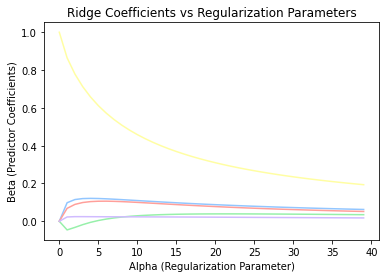

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import csv
import numpy as np
import pandas as pd
from pylab import *
from patsy import dmatrices


df = city_df_0.drop(["Lat", "Long"], axis = 1)

###scale the data to have mean 0 stdev 1
df_scaled = preprocessing.scale(df)
df_scaled=pd.DataFrame(df_scaled)


###list of predictors for legend
predictors = list(df.columns.values)[1:9]

###make response (ys) and predictors (xs)
xs = df_scaled.iloc[:,1:9]
ys = df_scaled.iloc[:,5]


coef=[]
alphas = range(0,40)

for a in alphas:
  ridgereg=Ridge(alpha=a)
  ridgereg.fit(xs,ys)
  coef.append(ridgereg.coef_)

###Make plot of Beta as a function of Alpha
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(alphas,coef)
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Beta (Predictor Coefficients)')
ax.set_title('Ridge Coefficients vs Regularization Parameters')
ax.axis('tight')

###Selecting lambda
scaler=StandardScaler()
X_std=scaler.fit_transform(xs)

###Fit Ridge regression through cross validation
regr_cv=RidgeCV(alphas=range(1,40))
model_cv=regr_cv.fit(X_std,ys)

print (model_cv.alpha_)

In [ ]:
# main_df_arg, x_axis, y_axis, x_axis_drop = [], drop_axis = 1, title_arg = "Data Analysis"
# independent_var, dependent_var, mediator_variable = []

city_df_0 = paranaque_df
city_df_0["lpol"] = lpol_data_dict["Paranaque_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_0, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Paranaque_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_1 = valenzuela_df
city_df_1["lpol"] = lpol_data_dict["Valenzuela_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_1, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Valenzuela_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_2 = taguig_df
city_df_2["lpol"] = lpol_data_dict["Taguig_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_2, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Taguig_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_3 = makati_df
city_df_3["lpol"] = lpol_data_dict["Makati_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_3, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Makati_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_4 = muntinlupa_df
city_df_4["lpol"] = lpol_data_dict["Muntinlupa_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_4, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Muntinlupa_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_5 = manila_df
city_df_5["lpol"] = lpol_data_dict["Manila_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_5, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Manila_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_6 = pasig_df
city_df_6["lpol"] = lpol_data_dict["Pasig_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_6, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Pasig_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_7 = las_Pinas_df
city_df_7["lpol"] = lpol_data_dict["Las Pinas_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_7, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Las Pinas_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_8 = pasay_df
city_df_8["lpol"] = lpol_data_dict["Pasay_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_8, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Pasay_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


In [ ]:
city_df_8 = malabon_df
city_df_8["lpol"] = lpol_data_dict["Malabon_City"]

model = MMREG_PROCS(
    main_df_arg = city_df_8, 
    x_axis = "lpol", 
    y_axis = "T2M", 
    x_axis_drop = ["Lat", "Long", "T2M"],
    title_arg = "Malabon_City"
    )
model.standard_proc()
model.mod_reg(
    independent_var = "lpol", 
    dependent_var = "T2M", 
    mediator_variable = ["PS", "QV2M", "PRECTOTCORR", "WS10M"])


<h1>Geographical Weighted Regression</h1>

In [ ]:
g_y = cities_df['T2M'].values.reshape((-1,1)) #T2M
cities_df["lpol"] = cities_df['lpol_avg']
g_X = cities_df[['QV2M', "PS", "WS10M", "PRECTOTCORR", "lpol_avg"]].values
g_coords = list(g_coords)

#normalize
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [ ]:
g_X[np.isnan(g_X)] = 0
g_y[np.isnan(g_y)] = 0

In [ ]:
gwr_selector = Sel_BW(g_coords, g_y, g_X, kernel = "gaussian", fixed = False, spherical=True) 
gwr_bw = gwr_selector.search(bw_min = 2)
gwr_bw

In [ ]:
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

In [ ]:
gwr_results.summary()

In [ ]:
gwr_filtered_t = gwr_results.filter_tvals()

In [ ]:
def show_plot_by_res_index(res_arg, var_ind_title):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
  ax.set_title("Variable " + var_ind_title + "  " + 'GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=12)

  cmap = plt.cm.seismic

  gwr_min = res_arg.min()
  gwr_max = res_arg.max()
  vmin = np.min([gwr_min])
  vmax = np.max([gwr_max])

  #If all values are negative use the negative half of the colormap
  if (vmin < 0) & (vmax < 0):
      cmap = truncate_colormap(cmap, 0.0, 0.5)
  #If all values are positive use the positive half of the colormap
  elif (vmin > 0) & (vmax > 0):
      cmap = truncate_colormap(cmap, 0.5, 1.0)
  #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
  else:
      cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
  NCR_geopckg.plot(cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':1})


  fig.tight_layout()    
  sm._A = []
  cbar = fig.colorbar(sm)
  cbar.ax.tick_params(labelsize=12) 
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.style.use('seaborn-pastel')
  plt.show()

<h1>Multi Scale Goegraphical Weighted Regression </h1>

In [ ]:
mgwr_selector = Sel_BW(g_coords, g_y, g_X, kernel = "bisquare", fixed = False, spherical=True, multi = True) 
mgwr_bw = mgwr_selector.search(multi_bw_min = [2])
mgwr_bw

In [ ]:
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()
mgwr_results.summary()

In [ ]:
mgwr_filtered_t = mgwr_results.filter_tvals()

In [ ]:
def MGWR_plot(res_arg, var_ind_title):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
  ax.set_title(var_ind_title + "  " + '(BW: ' + str(gwr_bw) +')', fontsize=12)

  cmap = plt.cm.seismic

  gwr_min = res_arg.min()
  gwr_max = res_arg.max()
  vmin = np.min([gwr_min])
  vmax = np.max([gwr_max])

  #If all values are negative use the negative half of the colormap
  if (vmin < 0) & (vmax < 0):
      cmap = truncate_colormap(cmap, 0.0, 0.5)
  #If all values are positive use the positive half of the colormap
  elif (vmin > 0) & (vmax > 0):
      cmap = truncate_colormap(cmap, 0.5, 1.0)
  #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
  else:
      cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
  #NCR_geopckg.plot(cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':1})

  #Plot MGWR parameters
  NCR_geopckg.plot(cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':1})



  fig.tight_layout()    
  sm._A = []
  cbar = fig.colorbar(sm)
  cbar.ax.tick_params(labelsize=12) 
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.style.use('seaborn-pastel')
  plt.show()

In [ ]:
MGWR_plot(gwr_results.params[:,0], "Change in WS |")
MGWR_plot(gwr_results.params[:,1], "Change in QV g/kg |")
MGWR_plot(gwr_results.params[:,2], "Change in PS |")
MGWR_plot(gwr_results.params[:,3], "Change in WS m/s |")
MGWR_plot(gwr_results.params[:,4], "Change in PRECTOTCORR mm/hr |")
MGWR_plot(gwr_results.params[:,5], "Change in Light pol |")